Without category

In [1]:
import torch
import torch.nn as nn
import pandas as pd
from torch.utils.data import Dataset, DataLoader
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Dataset class for grouped sequences of transactions by `cc_num`
class CreditCardFraudDataset(Dataset):
    def __init__(self, file_path, seq_len):
        self.data = pd.read_csv(file_path)

        # Convert date to timestamp
        self.data['trans_date_trans_time'] = pd.to_datetime(self.data['trans_date_trans_time']).apply(lambda x: x.timestamp())

        # Normalize the 'amt' feature
        scaler = MinMaxScaler()
        self.data[['amt']] = scaler.fit_transform(self.data[['amt']])

        # Group transactions by `cc_num` and create sequences
        self.seq_len = seq_len
        self.sequences = []
        grouped = self.data.groupby('cc_num')
        for _, group in grouped:
            # Only use 'amt', 'is_fraud', 'trans_date_trans_time'
            group = group[['amt', 'is_fraud', 'trans_date_trans_time']].values
            for i in range(len(group)):
                if i < self.seq_len - 1:
                    padding = [group[0]] * (self.seq_len - i - 1)
                    seq = padding + group[:i + 1].tolist()
                else:
                    seq = group[i - self.seq_len + 1:i + 1].tolist()

                label = group[i, 1]  # Fraud label (second column in 'amt', 'is_fraud', 'trans_date_trans_time')
                time_intervals = np.diff([s[-1] for s in seq], prepend=seq[0][-1])  # Time differences
                time_intervals = time_intervals.reshape(-1, 1)  # Reshape for compatibility
                seq_features = np.array([s[:-1] for s in seq])  # Remove timestamp from features (only 'amt' and 'is_fraud')
                seq_features = np.concatenate((seq_features, time_intervals), axis=1)  # Add time intervals as a feature
                self.sequences.append((seq_features, label))

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        x_seq, y_label = self.sequences[idx]
        return torch.tensor(x_seq, dtype=torch.float32), torch.tensor(y_label, dtype=torch.float32)


# TH-LSTM Model (with time-aware gate `T_t`)
class TH_LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, memory_size):
        super(TH_LSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.memory_size = memory_size

        # LSTM weights
        self.Wsh = nn.Linear(hidden_dim, hidden_dim)
        self.Wsx = nn.Linear(input_dim, hidden_dim)
        self.Wst = nn.Linear(1, hidden_dim)  # For time intervals
        self.bs = nn.Parameter(torch.zeros(hidden_dim))

        self.Wfh = nn.Linear(hidden_dim, hidden_dim)
        self.Wfx = nn.Linear(input_dim, hidden_dim)
        self.Wfs = nn.Linear(hidden_dim, hidden_dim)
        self.bf = nn.Parameter(torch.zeros(hidden_dim))

        self.Wih = nn.Linear(hidden_dim, hidden_dim)
        self.Wix = nn.Linear(input_dim, hidden_dim)
        self.Wis = nn.Linear(hidden_dim, hidden_dim)
        self.bi = nn.Parameter(torch.zeros(hidden_dim))

        self.Wuh = nn.Linear(hidden_dim, hidden_dim)
        self.Wux = nn.Linear(input_dim, hidden_dim)
        self.Wus = nn.Linear(hidden_dim, hidden_dim)
        self.bu = nn.Parameter(torch.zeros(hidden_dim))

        self.WTh = nn.Linear(hidden_dim, hidden_dim)
        self.WTx = nn.Linear(input_dim, hidden_dim)
        self.WTs = nn.Linear(hidden_dim, hidden_dim)
        self.bT = nn.Parameter(torch.zeros(hidden_dim))

        self.Woh = nn.Linear(hidden_dim, hidden_dim)
        self.Wox = nn.Linear(input_dim, hidden_dim)
        self.Wos = nn.Linear(hidden_dim, hidden_dim)
        self.bo = nn.Parameter(torch.zeros(hidden_dim))

        # Attention module
        self.Waq = nn.Linear(hidden_dim * 2, hidden_dim)
        self.Wah = nn.Linear(hidden_dim, hidden_dim)
        self.ba = nn.Parameter(torch.zeros(hidden_dim))
        self.vt = nn.Parameter(torch.randn(hidden_dim, 1))

        # Output layer
        self.classifier = nn.Linear(hidden_dim, 1)

    def forward(self, X_seq):
        batch_size = X_seq.size(0)
        seq_len = X_seq.size(1)
        h_prev = torch.zeros(batch_size, self.hidden_dim).to(X_seq.device)
        c_prev = torch.zeros(batch_size, self.hidden_dim).to(X_seq.device)
        historical_states = torch.zeros(batch_size, self.memory_size, self.hidden_dim).to(X_seq.device)

        for t in range(seq_len):
            x_t = X_seq[:, t, :-1]  # Features excluding delta_t
            delta_t = X_seq[:, t, -1].view(-1, 1)  # Time interval (delta_t)

            # Time-aware state
            s_t = torch.tanh(self.Wsh(h_prev) + self.Wsx(x_t) + self.Wst(delta_t) + self.bs)

            # Gates
            f_t = torch.sigmoid(self.Wfh(h_prev) + self.Wfx(x_t) + self.Wfs(s_t) + self.bf)
            i_t = torch.sigmoid(self.Wih(h_prev) + self.Wix(x_t) + self.Wis(s_t) + self.bi)
            T_t = torch.sigmoid(self.WTh(h_prev) + self.WTx(x_t) + self.WTs(s_t) + self.bT)  # Time-aware gate

            # Candidate cell state
            zeta_t = torch.tanh(self.Wuh(h_prev) + self.Wux(x_t) + self.Wus(s_t) + self.bu)

            # New cell state
            c_t = f_t * c_prev + i_t * zeta_t + T_t * s_t

            # Hidden state
            o_t = torch.sigmoid(self.Woh(h_prev) + self.Wox(x_t) + self.Wos(s_t) + self.bo)
            h_t = o_t * torch.tanh(c_t)

            # Save historical hidden states for attention
            historical_states = torch.cat((historical_states[:, 1:], h_t.unsqueeze(1)), dim=1)
            h_prev, c_prev = h_t, c_t

        # Attention mechanism
        q_t = torch.cat((h_t, c_t), dim=1)
        o_t_i = torch.tanh(self.Waq(q_t).unsqueeze(1) + self.Wah(historical_states))
        alpha_t_i = torch.exp(torch.matmul(o_t_i, self.vt)).squeeze(-1)
        alpha_t_i = alpha_t_i / torch.sum(alpha_t_i, dim=1, keepdim=True)
        e_t = torch.sum(alpha_t_i.unsqueeze(-1) * historical_states, dim=1)

        # Final classification
        y_pred = torch.sigmoid(self.classifier(e_t))
        return y_pred


# Training and testing
if __name__ == "__main__":
    batch_size = 32
    input_dim = 2  # amt, delta_t (no category)
    hidden_dim = 64
    memory_size = 10
    seq_len = 5

    train_dataset = CreditCardFraudDataset("/home/ducanh/Credit Card Transactions Fraud Detection/fraudTrain.csv", seq_len=seq_len)
    test_dataset = CreditCardFraudDataset("/home/ducanh/Credit Card Transactions Fraud Detection/fraudTest.csv", seq_len=seq_len)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    model = TH_LSTM(input_dim, hidden_dim, memory_size).to('cuda' if torch.cuda.is_available() else 'cpu')
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.BCELoss()

    epochs = 3
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        y_true_epoch = []
        y_pred_epoch = []

        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to('cuda'), y_batch.view(-1, 1).to('cuda')
            optimizer.zero_grad()
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

            y_true_epoch.extend(y_batch.cpu().numpy())
            y_pred_epoch.extend((y_pred.detach().cpu().numpy() >= 0.5).astype(int))

        epoch_accuracy = accuracy_score(y_true_epoch, y_pred_epoch)
        print(f"Epoch [{epoch + 1}/{epochs}] Loss: {total_loss / len(train_loader):.4f} | Accuracy: {epoch_accuracy:.4f}")

    # Testing
    model.eval()
    y_true_test = []
    y_pred_test_prob = []

    with torch.no_grad():
        for X_batch, y_batch in test_loader:  # Unpack 2 values
            X_batch, y_batch = X_batch.to('cuda'), y_batch.view(-1, 1).to('cuda')
            y_pred = model(X_batch)
            y_true_test.extend(y_batch.cpu().numpy())
            y_pred_test_prob.extend(y_pred.cpu().numpy())

    thresholds = [0.1, 0.2, 0.3, 0.4, 0.5]
    for threshold in thresholds:
        y_pred_test_binary = (np.array(y_pred_test_prob) >= threshold).astype(int)
        accuracy = accuracy_score(y_true_test, y_pred_test_binary)
        precision = precision_score(y_true_test, y_pred_test_binary)
        recall = recall_score(y_true_test, y_pred_test_binary)
        f1 = f1_score(y_true_test, y_pred_test_binary)
        auc = roc_auc_score(y_true_test, y_pred_test_binary)

        print(f"Threshold: {threshold:.2f} | Accuracy: {accuracy:.4f} | Precision: {precision:.4f} | Recall: {recall:.4f} | F1: {f1:.4f} | AUC: {auc:.4f}")

Epoch [1/3] Loss: 0.0029 | Accuracy: 0.9995
Epoch [2/3] Loss: 0.0006 | Accuracy: 0.9999
Epoch [3/3] Loss: 0.0008 | Accuracy: 0.9998
Threshold: 0.10 | Accuracy: 1.0000 | Precision: 0.9991 | Recall: 1.0000 | F1: 0.9995 | AUC: 1.0000
Threshold: 0.20 | Accuracy: 1.0000 | Precision: 0.9991 | Recall: 1.0000 | F1: 0.9995 | AUC: 1.0000
Threshold: 0.30 | Accuracy: 1.0000 | Precision: 0.9991 | Recall: 1.0000 | F1: 0.9995 | AUC: 1.0000
Threshold: 0.40 | Accuracy: 1.0000 | Precision: 0.9991 | Recall: 1.0000 | F1: 0.9995 | AUC: 1.0000
Threshold: 0.50 | Accuracy: 1.0000 | Precision: 0.9991 | Recall: 1.0000 | F1: 0.9995 | AUC: 1.0000


Without amt

In [2]:
import torch
import torch.nn as nn
import pandas as pd
from torch.utils.data import Dataset, DataLoader
import numpy as np
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Dataset class for grouped sequences of transactions by `cc_num`
class CreditCardFraudDataset(Dataset):
    def __init__(self, file_path, seq_len):
        self.data = pd.read_csv(file_path)

        # Convert date to timestamp
        self.data['trans_date_trans_time'] = pd.to_datetime(self.data['trans_date_trans_time']).apply(lambda x: x.timestamp())

        # Encode category column
        self.label_encoder = LabelEncoder()
        self.data['category'] = self.label_encoder.fit_transform(self.data['category'])

        # Group transactions by `cc_num` and create sequences
        self.seq_len = seq_len
        self.sequences = []
        grouped = self.data.groupby('cc_num')
        for _, group in grouped:
            # Only use 'category', 'is_fraud', 'trans_date_trans_time'
            group = group[['category', 'is_fraud', 'trans_date_trans_time']].values
            for i in range(len(group)):
                if i < self.seq_len - 1:
                    padding = [group[0]] * (self.seq_len - i - 1)
                    seq = padding + group[:i + 1].tolist()
                else:
                    seq = group[i - self.seq_len + 1:i + 1].tolist()

                label = group[i, 1]  # Fraud label (second column in 'category', 'is_fraud', 'trans_date_trans_time')
                time_intervals = np.diff([s[-1] for s in seq], prepend=seq[0][-1])  # Time differences
                time_intervals = time_intervals.reshape(-1, 1)  # Reshape for compatibility
                seq_features = np.array([s[:-1] for s in seq])  # Remove timestamp from features (only 'category' and 'is_fraud')
                seq_features = np.concatenate((seq_features, time_intervals), axis=1)  # Add time intervals as a feature
                self.sequences.append((seq_features, label))

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        x_seq, y_label = self.sequences[idx]
        return torch.tensor(x_seq, dtype=torch.float32), torch.tensor(y_label, dtype=torch.float32)


# TH-LSTM Model (with time-aware gate `T_t`)
class TH_LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, memory_size):
        super(TH_LSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.memory_size = memory_size

        # LSTM weights
        self.Wsh = nn.Linear(hidden_dim, hidden_dim)
        self.Wsx = nn.Linear(input_dim, hidden_dim)
        self.Wst = nn.Linear(1, hidden_dim)  # For time intervals
        self.bs = nn.Parameter(torch.zeros(hidden_dim))

        self.Wfh = nn.Linear(hidden_dim, hidden_dim)
        self.Wfx = nn.Linear(input_dim, hidden_dim)
        self.Wfs = nn.Linear(hidden_dim, hidden_dim)
        self.bf = nn.Parameter(torch.zeros(hidden_dim))

        self.Wih = nn.Linear(hidden_dim, hidden_dim)
        self.Wix = nn.Linear(input_dim, hidden_dim)
        self.Wis = nn.Linear(hidden_dim, hidden_dim)
        self.bi = nn.Parameter(torch.zeros(hidden_dim))

        self.Wuh = nn.Linear(hidden_dim, hidden_dim)
        self.Wux = nn.Linear(input_dim, hidden_dim)
        self.Wus = nn.Linear(hidden_dim, hidden_dim)
        self.bu = nn.Parameter(torch.zeros(hidden_dim))

        self.WTh = nn.Linear(hidden_dim, hidden_dim)
        self.WTx = nn.Linear(input_dim, hidden_dim)
        self.WTs = nn.Linear(hidden_dim, hidden_dim)
        self.bT = nn.Parameter(torch.zeros(hidden_dim))

        self.Woh = nn.Linear(hidden_dim, hidden_dim)
        self.Wox = nn.Linear(input_dim, hidden_dim)
        self.Wos = nn.Linear(hidden_dim, hidden_dim)
        self.bo = nn.Parameter(torch.zeros(hidden_dim))

        # Attention module
        self.Waq = nn.Linear(hidden_dim * 2, hidden_dim)
        self.Wah = nn.Linear(hidden_dim, hidden_dim)
        self.ba = nn.Parameter(torch.zeros(hidden_dim))
        self.vt = nn.Parameter(torch.randn(hidden_dim, 1))

        # Output layer
        self.classifier = nn.Linear(hidden_dim, 1)

    def forward(self, X_seq):
        batch_size = X_seq.size(0)
        seq_len = X_seq.size(1)
        h_prev = torch.zeros(batch_size, self.hidden_dim).to(X_seq.device)
        c_prev = torch.zeros(batch_size, self.hidden_dim).to(X_seq.device)
        historical_states = torch.zeros(batch_size, self.memory_size, self.hidden_dim).to(X_seq.device)

        for t in range(seq_len):
            x_t = X_seq[:, t, :-1]  # Features excluding delta_t
            delta_t = X_seq[:, t, -1].view(-1, 1)  # Time interval (delta_t)

            # Time-aware state
            s_t = torch.tanh(self.Wsh(h_prev) + self.Wsx(x_t) + self.Wst(delta_t) + self.bs)

            # Gates
            f_t = torch.sigmoid(self.Wfh(h_prev) + self.Wfx(x_t) + self.Wfs(s_t) + self.bf)
            i_t = torch.sigmoid(self.Wih(h_prev) + self.Wix(x_t) + self.Wis(s_t) + self.bi)
            T_t = torch.sigmoid(self.WTh(h_prev) + self.WTx(x_t) + self.WTs(s_t) + self.bT)  # Time-aware gate

            # Candidate cell state
            zeta_t = torch.tanh(self.Wuh(h_prev) + self.Wux(x_t) + self.Wus(s_t) + self.bu)

            # New cell state
            c_t = f_t * c_prev + i_t * zeta_t + T_t * s_t

            # Hidden state
            o_t = torch.sigmoid(self.Woh(h_prev) + self.Wox(x_t) + self.Wos(s_t) + self.bo)
            h_t = o_t * torch.tanh(c_t)

            # Save historical hidden states for attention
            historical_states = torch.cat((historical_states[:, 1:], h_t.unsqueeze(1)), dim=1)
            h_prev, c_prev = h_t, c_t

        # Attention mechanism
        q_t = torch.cat((h_t, c_t), dim=1)
        o_t_i = torch.tanh(self.Waq(q_t).unsqueeze(1) + self.Wah(historical_states))
        alpha_t_i = torch.exp(torch.matmul(o_t_i, self.vt)).squeeze(-1)
        alpha_t_i = alpha_t_i / torch.sum(alpha_t_i, dim=1, keepdim=True)
        e_t = torch.sum(alpha_t_i.unsqueeze(-1) * historical_states, dim=1)

        # Final classification
        y_pred = torch.sigmoid(self.classifier(e_t))
        return y_pred


# Training and testing
if __name__ == "__main__":
    batch_size = 32
    input_dim = 2  # category (encoded), delta_t
    hidden_dim = 64
    memory_size = 10
    seq_len = 5

    train_dataset = CreditCardFraudDataset("/home/ducanh/Credit Card Transactions Fraud Detection/fraudTrain.csv", seq_len=seq_len)
    test_dataset = CreditCardFraudDataset("/home/ducanh/Credit Card Transactions Fraud Detection/fraudTest.csv", seq_len=seq_len)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    model = TH_LSTM(input_dim, hidden_dim, memory_size).to('cuda' if torch.cuda.is_available() else 'cpu')
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.BCELoss()

    epochs = 3
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        y_true_epoch = []
        y_pred_epoch = []

        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to('cuda'), y_batch.view(-1, 1).to('cuda')
            optimizer.zero_grad()
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

            y_true_epoch.extend(y_batch.cpu().numpy())
            y_pred_epoch.extend((y_pred.detach().cpu().numpy() >= 0.5).astype(int))

        epoch_accuracy = accuracy_score(y_true_epoch, y_pred_epoch)
        print(f"Epoch [{epoch + 1}/{epochs}] Loss: {total_loss / len(train_loader):.4f} | Accuracy: {epoch_accuracy:.4f}")

    # Testing
    model.eval()
    y_true_test = []
    y_pred_test_prob = []

    with torch.no_grad():
        for X_batch, y_batch in test_loader:  # Unpack 2 values
            X_batch, y_batch = X_batch.to('cuda'), y_batch.view(-1, 1).to('cuda')
            y_pred = model(X_batch)
            y_true_test.extend(y_batch.cpu().numpy())
            y_pred_test_prob.extend(y_pred.cpu().numpy())

    thresholds = [0.1, 0.2, 0.3, 0.4, 0.5]
    for threshold in thresholds:
        y_pred_test_binary = (np.array(y_pred_test_prob) >= threshold).astype(int)
        accuracy = accuracy_score(y_true_test, y_pred_test_binary)
        precision = precision_score(y_true_test, y_pred_test_binary)
        recall = recall_score(y_true_test, y_pred_test_binary)
        f1 = f1_score(y_true_test, y_pred_test_binary)
        auc = roc_auc_score(y_true_test, y_pred_test_binary)

        print(f"Threshold: {threshold:.2f} | Accuracy: {accuracy:.4f} | Precision: {precision:.4f} | Recall: {recall:.4f} | F1: {f1:.4f} | AUC: {auc:.4f}")


Epoch [1/3] Loss: 0.0019 | Accuracy: 0.9995
Epoch [2/3] Loss: 0.0006 | Accuracy: 0.9999
Epoch [3/3] Loss: 0.0001 | Accuracy: 1.0000
Threshold: 0.10 | Accuracy: 1.0000 | Precision: 1.0000 | Recall: 1.0000 | F1: 1.0000 | AUC: 1.0000
Threshold: 0.20 | Accuracy: 1.0000 | Precision: 1.0000 | Recall: 1.0000 | F1: 1.0000 | AUC: 1.0000
Threshold: 0.30 | Accuracy: 1.0000 | Precision: 1.0000 | Recall: 1.0000 | F1: 1.0000 | AUC: 1.0000
Threshold: 0.40 | Accuracy: 1.0000 | Precision: 1.0000 | Recall: 1.0000 | F1: 1.0000 | AUC: 1.0000
Threshold: 0.50 | Accuracy: 1.0000 | Precision: 1.0000 | Recall: 1.0000 | F1: 1.0000 | AUC: 1.0000


Without time

In [1]:
import torch
import torch.nn as nn
import pandas as pd
from torch.utils.data import Dataset, DataLoader
import numpy as np
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import random

# Dataset class for grouped sequences of transactions by `cc_num`
class CreditCardFraudDataset(Dataset):
    def __init__(self, data, seq_len):
        self.data = data.copy()

        # Encode category column
        self.label_encoder = LabelEncoder()
        self.data['category'] = self.label_encoder.fit_transform(self.data['category'])

        # Normalize features
        scaler = MinMaxScaler()
        self.data[['amt']] = scaler.fit_transform(self.data[['amt']])

        # Group transactions by `cc_num` and create sequences
        self.seq_len = seq_len
        self.sequences = []
        grouped = self.data.groupby('cc_num')
        for _, group in grouped:
            group = group[['category', 'amt', 'is_fraud']].values
            for i in range(len(group)):
                if i < self.seq_len - 1:
                    padding = [group[0]] * (self.seq_len - i - 1)
                    seq = padding + group[:i + 1].tolist()
                else:
                    seq = group[i - self.seq_len + 1:i + 1].tolist()

                label = group[i, -1]  # Fraud label of the current transaction
                seq_features = np.array([s[:-1] for s in seq])  # Remove the fraud label from features
                self.sequences.append((seq_features, label))

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        x_seq, y_label = self.sequences[idx]
        return torch.tensor(x_seq, dtype=torch.float32), torch.tensor(y_label, dtype=torch.float32)


# Updated TH-LSTM Model (without time-aware gate `T_t`)
class TH_LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, memory_size):
        super(TH_LSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.memory_size = memory_size

        # LSTM weights
        self.Wsh = nn.Linear(hidden_dim, hidden_dim)
        self.Wsx = nn.Linear(input_dim, hidden_dim)
        self.bs = nn.Parameter(torch.zeros(hidden_dim))

        self.Wfh = nn.Linear(hidden_dim, hidden_dim)
        self.Wfx = nn.Linear(input_dim, hidden_dim)
        self.Wfs = nn.Linear(hidden_dim, hidden_dim)
        self.bf = nn.Parameter(torch.zeros(hidden_dim))

        self.Wih = nn.Linear(hidden_dim, hidden_dim)
        self.Wix = nn.Linear(input_dim, hidden_dim)
        self.Wis = nn.Linear(hidden_dim, hidden_dim)
        self.bi = nn.Parameter(torch.zeros(hidden_dim))

        self.Wuh = nn.Linear(hidden_dim, hidden_dim)
        self.Wux = nn.Linear(input_dim, hidden_dim)
        self.Wus = nn.Linear(hidden_dim, hidden_dim)
        self.bu = nn.Parameter(torch.zeros(hidden_dim))

        self.Woh = nn.Linear(hidden_dim, hidden_dim)
        self.Wox = nn.Linear(input_dim, hidden_dim)
        self.Wos = nn.Linear(hidden_dim, hidden_dim)
        self.bo = nn.Parameter(torch.zeros(hidden_dim))

        # Attention module
        self.Waq = nn.Linear(hidden_dim * 2, hidden_dim)
        self.Wah = nn.Linear(hidden_dim, hidden_dim)
        self.ba = nn.Parameter(torch.zeros(hidden_dim))
        self.vt = nn.Parameter(torch.randn(hidden_dim, 1))

        # Output layer
        self.classifier = nn.Linear(hidden_dim, 1)

    def forward(self, X_seq):
        batch_size = X_seq.size(0)
        seq_len = X_seq.size(1)
        h_prev = torch.zeros(batch_size, self.hidden_dim).to(X_seq.device)
        c_prev = torch.zeros(batch_size, self.hidden_dim).to(X_seq.device)
        historical_states = torch.zeros(batch_size, self.memory_size, self.hidden_dim).to(X_seq.device)

        for t in range(seq_len):
            x_t = X_seq[:, t, :]

            s_t = torch.tanh(self.Wsh(h_prev) + self.Wsx(x_t) + self.bs)
            f_t = torch.sigmoid(self.Wfh(h_prev) + self.Wfx(x_t) + self.Wfs(s_t) + self.bf)
            i_t = torch.sigmoid(self.Wih(h_prev) + self.Wix(x_t) + self.Wis(s_t) + self.bi)
            zeta_t = torch.tanh(self.Wuh(h_prev) + self.Wux(x_t) + self.Wus(s_t) + self.bu)
            c_t = f_t * c_prev + i_t * zeta_t
            o_t = torch.sigmoid(self.Woh(h_prev) + self.Wox(x_t) + self.Wos(s_t) + self.bo)
            h_t = o_t * torch.tanh(c_t)

            historical_states = torch.cat((historical_states[:, 1:], h_t.unsqueeze(1)), dim=1)
            h_prev, c_prev = h_t, c_t

        q_t = torch.cat((h_t, c_t), dim=1)
        o_t_i = torch.tanh(self.Waq(q_t).unsqueeze(1) + self.Wah(historical_states))
        alpha_t_i = torch.exp(torch.matmul(o_t_i, self.vt)).squeeze(-1)
        alpha_t_i = alpha_t_i / torch.sum(alpha_t_i, dim=1, keepdim=True)
        e_t = torch.sum(alpha_t_i.unsqueeze(-1) * historical_states, dim=1)

        y_pred = torch.sigmoid(self.classifier(e_t))
        return y_pred


# Training and testing
if __name__ == "__main__":
    batch_size = 32
    input_dim = 2  # category, amt
    hidden_dim = 32
    memory_size = 10
    seq_len = 5
    epochs = 3

    # Load training dataset
    train_data = pd.read_csv("/home/ducanh/Credit Card Transactions Fraud Detection/fraudTrain.csv")

    # Split the training data into 80% for train and 20% for validation
    all_cc_nums = train_data['cc_num'].unique()
    random.shuffle(all_cc_nums)

    train_cc_nums = all_cc_nums[:int(0.8 * len(all_cc_nums))]
    val_cc_nums = all_cc_nums[int(0.8 * len(all_cc_nums)):]

    new_train_data = train_data[train_data['cc_num'].isin(train_cc_nums)]
    new_val_data = train_data[train_data['cc_num'].isin(val_cc_nums)]

    print(f"New train size: {len(new_train_data)} transactions")
    print(f"New validation size: {len(new_val_data)} transactions")

    # Create datasets and loaders
    train_dataset = CreditCardFraudDataset(new_train_data, seq_len=seq_len)
    val_dataset = CreditCardFraudDataset(new_val_data, seq_len=seq_len)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    # Define model
    model = TH_LSTM(input_dim, hidden_dim, memory_size).to('cuda' if torch.cuda.is_available() else 'cpu')
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.BCELoss()

    # Training loop with accuracy and validation metrics at different thresholds
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        train_preds = []
        train_labels = []

        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to('cuda'), y_batch.view(-1, 1).to('cuda')
            optimizer.zero_grad()
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

            # Collect predictions and labels for training accuracy
            train_preds.extend(y_pred.detach().cpu().numpy())
            train_labels.extend(y_batch.detach().cpu().numpy())

        train_preds = np.array(train_preds).flatten()
        train_labels = np.array(train_labels).flatten()
        train_pred_binary = (train_preds >= 0.5).astype(int)
        train_accuracy = accuracy_score(train_labels, train_pred_binary)

        print(f"Epoch [{epoch + 1}/{epochs}] Loss: {total_loss / len(train_loader):.4f} | Train Accuracy: {train_accuracy:.4f}")

        # Evaluate on validation set
        model.eval()
        val_preds = []
        val_labels = []

        with torch.no_grad():
            for X_val, y_val in val_loader:
                X_val, y_val = X_val.to('cuda'), y_val.view(-1, 1).to('cuda')
                y_val_pred = model(X_val)
                val_preds.extend(y_val_pred.cpu().numpy())
                val_labels.extend(y_val.cpu().numpy())

        val_preds = np.array(val_preds).flatten()
        val_labels = np.array(val_labels).flatten()

        # Calculate metrics for each threshold
        thresholds = [0.1, 0.2, 0.3, 0.4, 0.5]
        print("Validation Metrics:")
        for threshold in thresholds:
            y_pred_thresholded = (val_preds >= threshold).astype(int)
            accuracy = accuracy_score(val_labels, y_pred_thresholded)
            precision = precision_score(val_labels, y_pred_thresholded, zero_division=0)
            recall = recall_score(val_labels, y_pred_thresholded)
            f1 = f1_score(val_labels, y_pred_thresholded)
            auc = roc_auc_score(val_labels, val_preds)
            
            print(f"Threshold: {threshold:.2f} | Accuracy: {accuracy:.4f} | Precision: {precision:.4f} | Recall: {recall:.4f} | F1: {f1:.4f} | AUC: {auc:.4f}")

New train size: 1050447 transactions
New validation size: 246228 transactions
Epoch [1/3] Loss: 0.0327 | Train Accuracy: 0.9942
Validation Metrics:
Threshold: 0.10 | Accuracy: 0.9697 | Precision: 0.1380 | Recall: 0.7592 | F1: 0.2335 | AUC: 0.9416
Threshold: 0.20 | Accuracy: 0.9832 | Precision: 0.2187 | Recall: 0.6865 | F1: 0.3317 | AUC: 0.9416
Threshold: 0.30 | Accuracy: 0.9901 | Precision: 0.3345 | Recall: 0.6291 | F1: 0.4368 | AUC: 0.9416
Threshold: 0.40 | Accuracy: 0.9942 | Precision: 0.5221 | Recall: 0.5290 | F1: 0.5255 | AUC: 0.9416
Threshold: 0.50 | Accuracy: 0.9953 | Precision: 0.7576 | Recall: 0.3336 | F1: 0.4632 | AUC: 0.9416
Epoch [2/3] Loss: 0.0148 | Train Accuracy: 0.9965
Validation Metrics:
Threshold: 0.10 | Accuracy: 0.9575 | Precision: 0.1166 | Recall: 0.9099 | F1: 0.2067 | AUC: 0.9737
Threshold: 0.20 | Accuracy: 0.9735 | Precision: 0.1733 | Recall: 0.8886 | F1: 0.2900 | AUC: 0.9737
Threshold: 0.30 | Accuracy: 0.9812 | Precision: 0.2261 | Recall: 0.8599 | F1: 0.3581 | AU

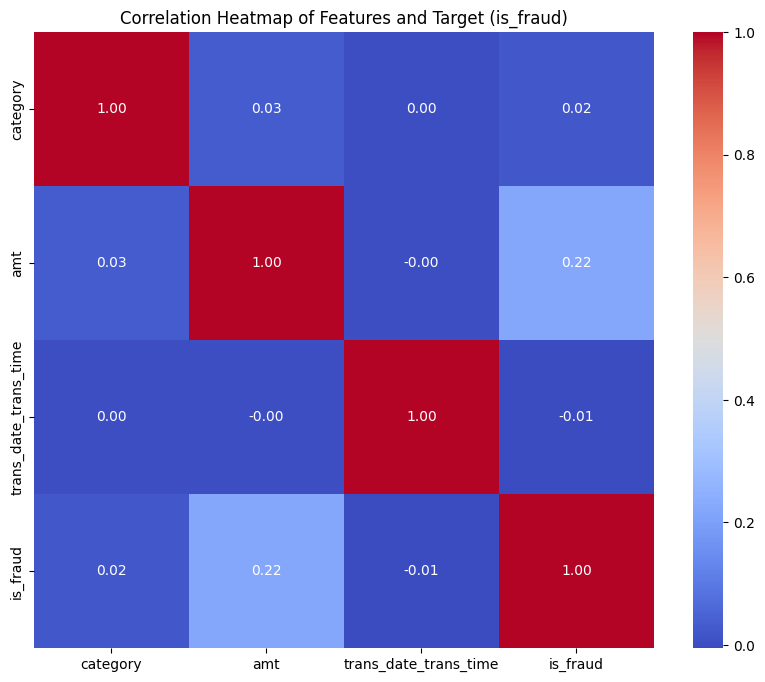

/tmp/ipykernel_1600298/1803008352.py:42: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importance, palette='viridis')


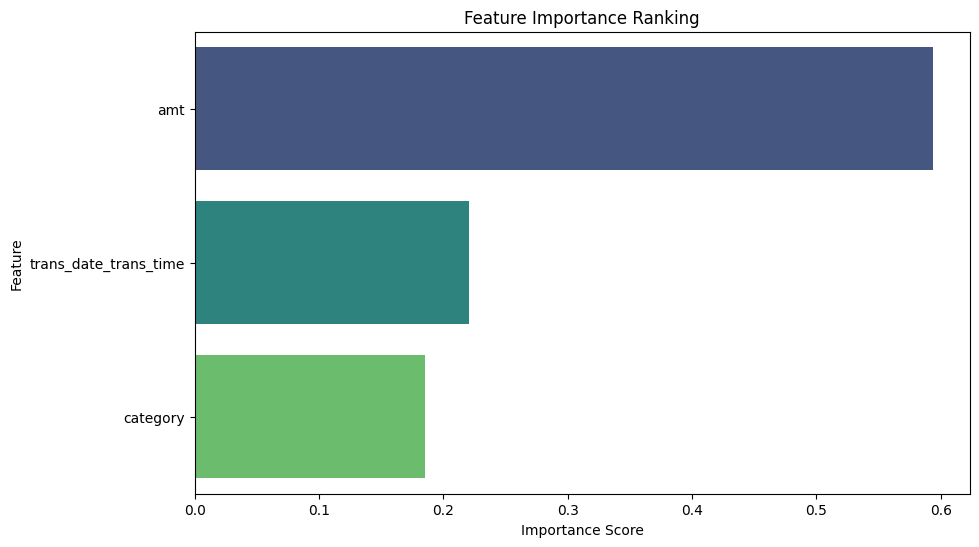

,Feature,Importance
0,amt,0.593642
1,trans_date_trans_time,0.221024
2,category,0.185333


In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

# Load dataset
file_path = "/home/ducanh/Credit Card Transactions Fraud Detection/fraudTrain.csv"
data = pd.read_csv(file_path)

# Convert date to timestamp
data['trans_date_trans_time'] = pd.to_datetime(data['trans_date_trans_time']).apply(lambda x: x.timestamp())

# Encode categorical column
label_encoder = LabelEncoder()
data['category'] = label_encoder.fit_transform(data['category'])

# Normalize features
scaler = MinMaxScaler()
data[['amt']] = scaler.fit_transform(data[['amt']])

# Remove target from features for correlation
feature_cols = ['category', 'amt', 'trans_date_trans_time']
correlation_matrix = data[feature_cols + ['is_fraud']].corr()

# Plot correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap of Features and Target (is_fraud)')
plt.show()

# Feature importance ranking using Random Forest
X = data[feature_cols]
y = data['is_fraud']
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X, y)
feature_importance = pd.DataFrame({'Feature': feature_cols, 'Importance': rf_model.feature_importances_})
feature_importance = feature_importance.sort_values(by='Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance, palette='viridis')
plt.title('Feature Importance Ranking')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.show()

# Display feature importance table
feature_importance.reset_index(drop=True, inplace=True)
feature_importance

In [3]:
# Load dataset
file_path = "/home/ducanh/Credit Card Transactions Fraud Detection/fraudTrain.csv"
data = pd.read_csv(file_path)

In [6]:
data['trans_date_trans_time'] = pd.to_datetime(data['trans_date_trans_time']).apply(lambda x: x.timestamp())

In [8]:
label_encoder = LabelEncoder()
data['category'] = label_encoder.fit_transform(data['category'])

# Normalize features
scaler = MinMaxScaler()
data[['amt']] = scaler.fit_transform(data[['amt']])

In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1296675 entries, 0 to 1296674
Data columns (total 23 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   Unnamed: 0             1296675 non-null  int64  
 1   trans_date_trans_time  1296675 non-null  float64
 2   cc_num                 1296675 non-null  int64  
 3   merchant               1296675 non-null  object 
 4   category               1296675 non-null  int64  
 5   amt                    1296675 non-null  float64
 6   first                  1296675 non-null  object 
 7   last                   1296675 non-null  object 
 8   gender                 1296675 non-null  object 
 9   street                 1296675 non-null  object 
 10  city                   1296675 non-null  object 
 11  state                  1296675 non-null  object 
 12  zip                    1296675 non-null  int64  
 13  lat                    1296675 non-null  float64
 14  long              

In [15]:
data = data.drop(columns= 'merchant')

In [ ]:
data = data

In [20]:
grouped = self.data.groupby('cc_num')
        for _, group in grouped:
            group = group[['category', 'amt', 'is_fraud', 'trans_date_trans_time']].values

IndentationError: unexpected indent (1187516086.py, line 2)

In [17]:
drop_col = [ 'merchant','first', 'last', 'street', 'city', 'state', 'lat',
       'long','dob', 'unix_time', 'merch_lat',
       'merch_long', 'trans_year_month', 'cust_age','city_pop',
       'city-state', 'lon1', 'lon2', 'lat1', 'lat2', 'dlon',
       'dlat', 'a', 'c', 'distance_bw_cust_merch_in_miles',
       'distance_cust_merch']

In [21]:
# Convert datetime column to timestamp
data['trans_date_trans_time'] = pd.to_datetime(data['trans_date_trans_time']).apply(lambda x: x.timestamp())

# Encode 'category' column (since it's categorical)
label_encoder = LabelEncoder()
data['category'] = label_encoder.fit_transform(data['category'])

# Normalize 'amt' (transaction amount)
scaler = MinMaxScaler()
data[['amt']] = scaler.fit_transform(data[['amt']])

# Select the requested features
selected_features = ['category', 'amt', 'is_fraud', 'trans_date_trans_time']
selected_data = data[selected_features]

In [23]:
# Load dataset
file_path = "/home/ducanh/Credit Card Transactions Fraud Detection/fraudTrain.csv"
data = pd.read_csv(file_path)

In [25]:
selected_features = ['category', 'amt', 'trans_date_trans_time', 'is_fraud']

df = data[selected_features]

In [26]:
# Convert datetime column to timestamp
df['trans_date_trans_time'] = pd.to_datetime(df['trans_date_trans_time']).apply(lambda x: x.timestamp())

# Encode 'category' column (since it's categorical)
label_encoder = LabelEncoder()
df['category'] = label_encoder.fit_transform(df['category'])


/tmp/ipykernel_1600298/764426561.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['trans_date_trans_time'] = pd.to_datetime(df['trans_date_trans_time']).apply(lambda x: x.timestamp())
/tmp/ipykernel_1600298/764426561.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['category'] = label_encoder.fit_transform(df['category'])


In [27]:
df.head()

,category,amt,trans_date_trans_time,is_fraud
0,8,4.97,1.546301e+09,0
1,4,107.23,1.546301e+09,0
2,0,220.11,1.546301e+09,0
3,2,45.00,1.546301e+09,0
4,9,41.96,1.546301e+09,0


In [29]:
df.corr()

,category,amt,trans_date_trans_time,is_fraud
category,1.000000,0.030867,0.000180,0.020205
amt,0.030867,1.000000,-0.000285,0.219404
trans_date_trans_time,0.000180,-0.000285,1.000000,-0.005041
is_fraud,0.020205,0.219404,-0.005041,1.000000


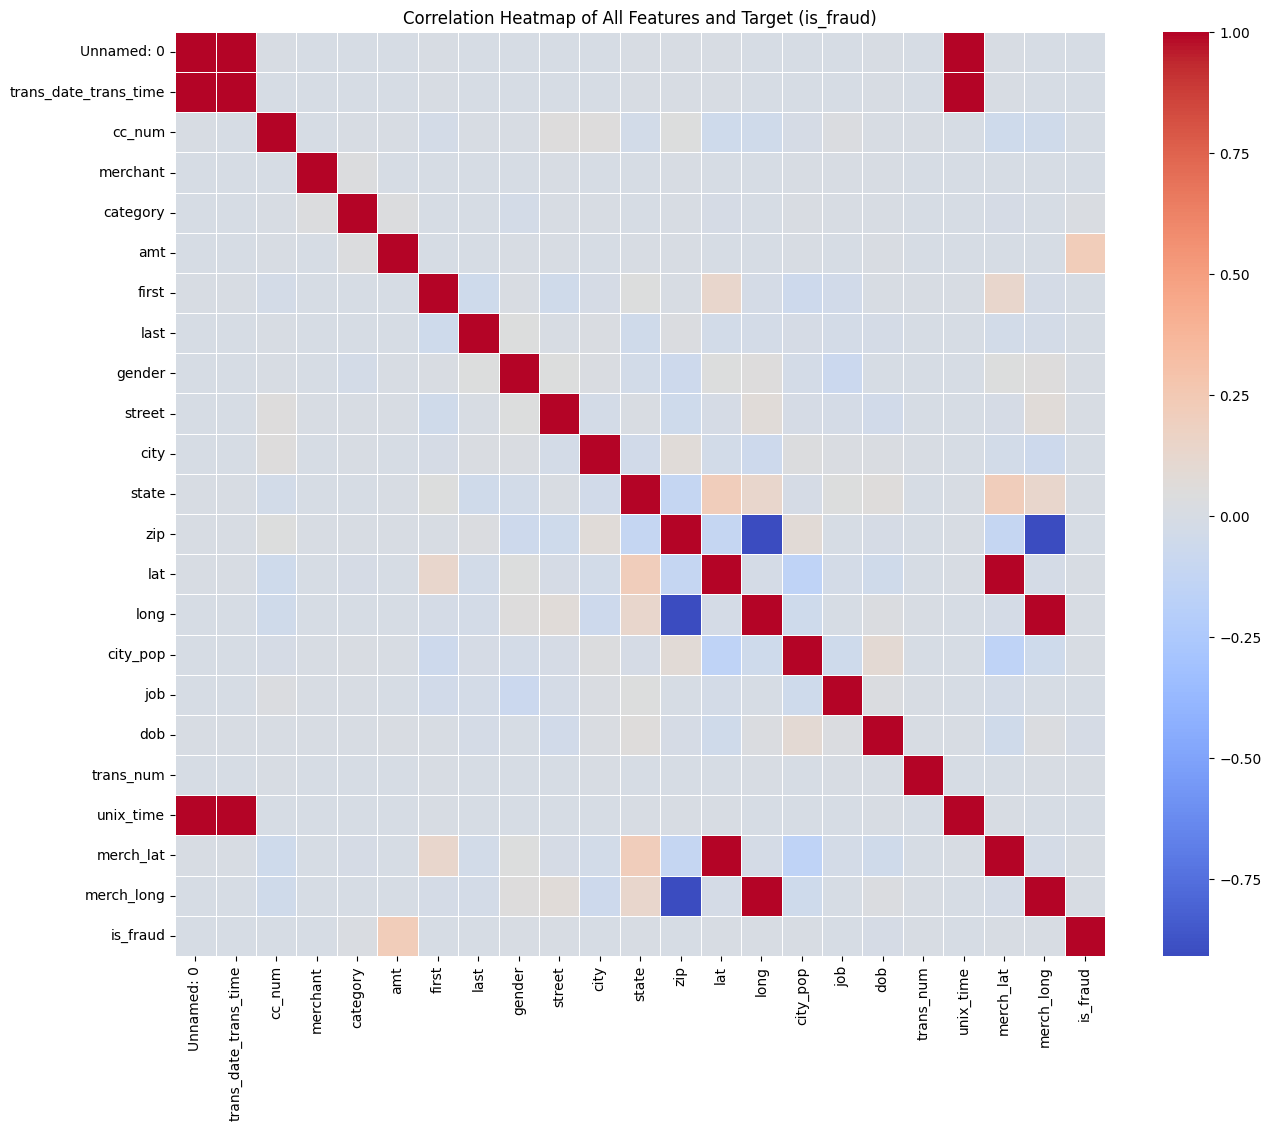

KeyboardInterrupt: 

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

# Load dataset
file_path = "/home/ducanh/Credit Card Transactions Fraud Detection/fraudTrain.csv"
data = pd.read_csv(file_path)

# Convert datetime columns to timestamps
data['trans_date_trans_time'] = pd.to_datetime(data['trans_date_trans_time']).apply(lambda x: x.timestamp())
data['dob'] = pd.to_datetime(data['dob']).apply(lambda x: x.timestamp())

# Encode categorical features
categorical_cols = ['merchant', 'category', 'first', 'last', 'gender', 'street', 'city', 'state', 'job', 'trans_num']
for col in categorical_cols:
    label_encoder = LabelEncoder()
    data[col] = label_encoder.fit_transform(data[col])

# Normalize numerical features
numerical_cols = ['amt', 'zip', 'lat', 'long', 'city_pop', 'unix_time', 'merch_lat', 'merch_long']
scaler = MinMaxScaler()
data[numerical_cols] = scaler.fit_transform(data[numerical_cols])

# List all features (excluding the target `is_fraud`)
feature_cols = data.columns.drop('is_fraud')

# Correlation matrix including all features
correlation_matrix = data[feature_cols.tolist() + ['is_fraud']].corr()

# Plot correlation heatmap
plt.figure(figsize=(15, 12))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap of All Features and Target (is_fraud)')
plt.show()

# Feature importance ranking using Random Forest
X = data[feature_cols]
y = data['is_fraud']
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X, y)
feature_importance = pd.DataFrame({'Feature': feature_cols, 'Importance': rf_model.feature_importances_})
feature_importance = feature_importance.sort_values(by='Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance, palette='viridis')
plt.title('Feature Importance Ranking of All Features')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.show()

# Display feature importance table
feature_importance.reset_index(drop=True, inplace=True)
import ace_tools as tools; tools.display_dataframe_to_user(name="Feature Importance Table", dataframe=feature_importance)


<Figure size 800x600 with 0 Axes>

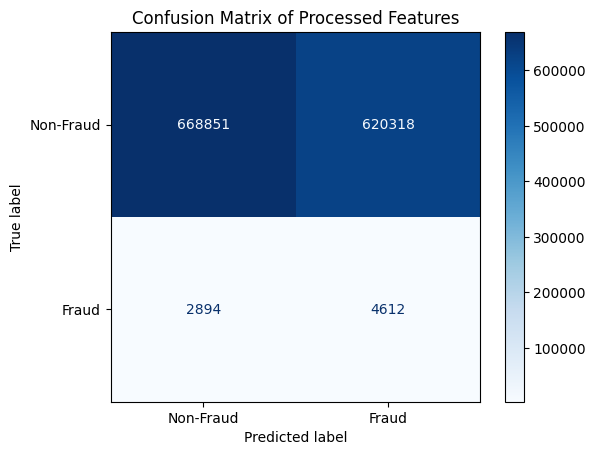

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Load the data
file_path = "/home/ducanh/Credit Card Transactions Fraud Detection/fraudTrain.csv"
data = pd.read_csv(file_path)

# Convert date to timestamp
data['trans_date_trans_time'] = pd.to_datetime(data['trans_date_trans_time']).apply(lambda x: x.timestamp())

# Encode the category column
label_encoder = LabelEncoder()
data['category'] = label_encoder.fit_transform(data['category'])

# Normalize amt feature
scaler = MinMaxScaler()
data[['amt']] = scaler.fit_transform(data[['amt']])

# Create sequences
seq_len = 5  # Sequence length
sequences = []
labels = []

grouped = data.groupby('cc_num')
for _, group in grouped:
    group = group[['category', 'amt', 'is_fraud', 'trans_date_trans_time']].values
    for i in range(len(group)):
        if i < seq_len - 1:
            padding = [group[0]] * (seq_len - i - 1)
            seq = padding + group[:i + 1].tolist()
        else:
            seq = group[i - seq_len + 1:i + 1].tolist()

        label = group[i, -2]  # Fraud label of the current transaction
        time_intervals = np.diff([s[-1] for s in seq], prepend=seq[0][-1])  # Time differences
        time_intervals = time_intervals.reshape(-1, 1)  # Reshape for compatibility
        seq_features = np.array([s[:-1] for s in seq])  # Remove timestamp from features
        seq_features = np.concatenate((seq_features, time_intervals), axis=1)  # Add time intervals as feature

        # Compute features for correlation
        category_mean = seq_features[:, 0].mean()
        amt_mean = seq_features[:, 1].mean()
        delta_t_mean = seq_features[:, 2].mean()
        sequences.append([category_mean, amt_mean, delta_t_mean])
        labels.append(label)

# Convert to DataFrame
processed_data = pd.DataFrame(sequences, columns=['category_mean', 'amt_mean', 'delta_t_mean'])
processed_data['label'] = labels

# Binarize predictions based on category_mean for simplicity (demo purpose)
processed_data['predicted_label'] = (processed_data['category_mean'] > processed_data['category_mean'].mean()).astype(int)

# Confusion matrix
conf_matrix = confusion_matrix(processed_data['label'], processed_data['predicted_label'])
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['Non-Fraud', 'Fraud'])

# Plot
plt.figure(figsize=(8, 6))
disp.plot(cmap="Blues")
plt.title("Confusion Matrix of Processed Features")
plt.show()

category_mean      0.028567
amt_mean           0.350177
delta_t_mean       0.884563
predicted_label    0.020233
Name: label, dtype: float64


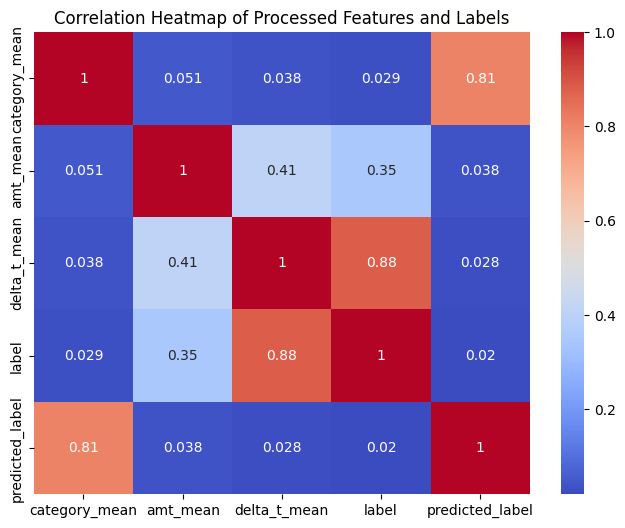

In [3]:
# Tính hệ số tương quan giữa các đặc trưng và nhãn is_fraud
correlation_matrix = processed_data.corr()

# Lấy mối tương quan với 'label'
correlations_with_label = correlation_matrix['label'].drop('label')
print(correlations_with_label)

# Vẽ biểu đồ heatmap để trực quan hóa
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap of Processed Features and Labels")
plt.show()